# PR3: Text Clustering with DBSCAN

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 21, 2018
* Description: Text clustering using DBCAN clustering algorithm
-----------

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# OS & sys
import os
import sys
import glob

# Version check
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import xgboost as xgb
import lightgbm as lgb


# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Manifold Learning
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, chi2, RFECV, SelectFromModel, RFE

# Text Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Metrics 
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer

# Decomposition
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA, NMF, FactorAnalysis, FastICA

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

# Utils
from collections import Counter, defaultdict

# Statistics
from scipy import stats, sparse

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

The scikit-learn version is 0.20.0.


In [2]:
with open('train.dat', 'r') as fh:
#     data = fh.readlines()
    data = fh.read().splitlines() 

In [3]:
len(data)

8580

In [4]:
def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

In [5]:
row_pairs = []
inds = []
vals = []
ptrs = [0]
for row_idx, row in enumerate(data):
    
    document = row.strip().split()
    if len(document) % 2 != 0:
        raise ValueError("document length is not correct...")
    doc_length = len(document)//2
    
    ptrs.append(ptrs[-1] + doc_length)
    for index, count in grouped(row.split(), 2):
#         row_pairs.append((index, count))
        inds.append(int(index))
        vals.append(int(count))
#         print(int(index), int(count))


In [7]:
data_csr = sparse.csr_matrix((vals,inds,ptrs), dtype=int)

In [8]:
# Word transformer
# X = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True).fit_transform(data_csr)
X = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False).fit_transform(data_csr)

In [9]:
X.shape

(8580, 126356)

In [14]:
# Goal is to minmize squared reconstruction error
selector = TruncatedSVD(n_components=5, algorithm="arpack", random_state=8)
X = selector.fit_transform(X)

In [15]:
X = sparse.csr_matrix(X)

In [16]:
def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

In [17]:
X = csr_l2normalize(X, copy=True)

In [18]:
def cosine_similarity_sparse(s1, s2):
    '''Calculate cosine similiarity of two sparse matrices'''
    # Calculate dot product (already L2 norm vectors so we do not need to divide)
    numerator = s1.dot(s2.T)
    return numerator


def cosine_distance_sparse(s1, s2):
    '''Calculate cosine distance of two sparse matrices (1 - cosine_similarity)'''
    # Calculate dot product (already L2 norm vectors so we do not need to divide)
    cos_sim = s1.dot(s2.T)
#     print(cos_sim.shape)
    if s1.shape[0] > s2.shape[0]:
        one_array = np.ones((s1.shape[0], 1), dtype=float)
    else:
        one_array = np.ones((s2.shape[0], 1), dtype=float)
    return np.array(one_array - cos_sim)

In [19]:
def find_neighbors(data, query, eps):
    distances = cosine_distance_sparse(data, query)
    indices = np.arange(data.shape[0])
    neighbors = indices[np.ravel(distances < eps)]
    return neighbors

In [20]:
def generate_cluster(data, labels, q, neighbors, c_id, eps, minPts, border_pts):
   
    labels[q] = c_id
    i = 0
    while i < len(neighbors):    
        new_point = neighbors[i]
        if labels[new_point] == -1:
            labels[new_point] = c_id
            border_pts.append(new_point)
        
        elif labels[new_point] == 0:
            labels[new_point] = c_id
            
            new_neighbors = find_neighbors(data, data[new_point], eps)
            if len(new_neighbors) >= minPts:
                neighbors = np.concatenate((neighbors, new_neighbors), axis=None)
        i += 1        
        
    return labels, border_pts

In [21]:
def DBSCAN(data, eps, minPts):
    labels = np.zeros(data.shape[0], dtype=int)
    c_id = 0
    
    core_pts = []
    border_pts = []
    
    for q in range(0, data.shape[0]):

        if labels[q] != 0:
            continue

        neighbors = find_neighbors(data, data[q], eps)
        if len(neighbors) < minPts:
            labels[q] = -1
        else: 
            c_id += 1
            core_pts.append(q)
            labels, border_pts = generate_cluster(data, labels, q, neighbors, c_id, eps, minPts, border_pts)
    return labels, core_pts, border_pts

In [22]:
def assign_noise_cluster(data, ids, K=5):
    """Use K nearest neighbors and majority voting to assign noise points to potential new clusters"""
    noise_ind = np.argwhere(ids==-1).ravel()
    n_clusters_ = len(set(ids)) - (1 if -1 in ids else 0)
    for q in noise_ind:
        distances = cosine_distance_sparse(data, data[q])
        neighbors = np.argsort(distances.ravel())[1:K+1]
        neighbor_ids = ids[neighbors]
        optimal_dists = distances[neighbors]
        count = Counter(neighbor_ids).most_common()
        if len(count) == 1 or count[0][1] > count[1][1]:
            if count[0][0] == -1:
                ids[q] = n_clusters_ + 1
            else:
#                 print("Found a simliar noise point to a existing cluster")
                ids[q] = count[0][0]
            continue
        num_n = count[0][1]
        keep_ids = [l for l, c in count if c == num_n]
        tc = defaultdict(float)
        # Distance-Weighted Voting
        for c_id, dist in zip(neighbor_ids, optimal_dists):
            if c_id not in keep_ids:
                continue
            else:
                tc[c_id] += (1 / (dist ** 2))
        if sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0] == -1:
            ids[q] = n_clusters_ + 1
        else:
#             print("Found a simliar noise point to a existing cluster")
            ids[q] = sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0]
        
    return ids

In [23]:
def assign_noise_KNN(data, ids, K=5):
    """Use K nearest neighbors and majority voting to assign noise points to existing clusters"""
    noise_ind = np.argwhere(ids==-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    for q in noise_ind:
        distances = cosine_distance_sparse(no_noise_data, data[q])
        pseudo_neighbors = np.argsort(distances.ravel())[:K]
        neighbor_ids = no_noise_ids[pseudo_neighbors]
        optimal_dists = distances[pseudo_neighbors]

        count = Counter(neighbor_ids).most_common()
#         print(count)
        if len(count) == 1 or count[0][1] > count[1][1]:
            ids[q] = count[0][0]
            continue
        num_n = count[0][1]
        keep_ids = [l for l, c in count if c == num_n]
        tc = defaultdict(float)
        # Distance-Weighted Voting
        for c_id, dist in zip(neighbor_ids, optimal_dists):
            if c_id not in keep_ids:
                continue
            else:
                tc[c_id] += (1 / (dist ** 2))
        ids[q] = sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0]
        
    return ids

In [24]:
def assign_noise_to_core(data, ids, core_pts, border_pts):
    noise_ind = np.argwhere(ids==-1).ravel()
    no_noise_ind = np.argwhere(ids!=-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    for q in noise_ind:
        distances = cosine_distance_sparse(no_noise_data, data[q])
        neighbors = np.argsort(distances.ravel())
        nearest_core_ind = next((x for x in no_noise_ind[neighbors] if x in core_pts), -1)
        ids[q] = ids[nearest_core_ind]
    return ids

In [25]:
def assign_noise_to_border(data, ids, core_pts, border_pts):
    noise_ind = np.argwhere(ids==-1).ravel()
    no_noise_ind = np.argwhere(ids!=-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    for q in noise_ind:
        distances = cosine_distance_sparse(no_noise_data, data[q])
        neighbors = np.argsort(distances.ravel())
        nearest_core_ind = next((x for x in no_noise_ind[neighbors] if x in border_pts), -1)
        ids[q] = ids[nearest_core_ind]
    return ids

In [26]:
def assign_noise_to_closest(data, ids, core_pts, border_pts):
    noise_ind = np.argwhere(ids==-1).ravel()
    no_noise_ind = np.argwhere(ids!=-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    core_border = core_pts + border_pts
    for q in noise_ind:
        distances = cosine_distance_sparse(no_noise_data, data[q])
        neighbors = np.argsort(distances.ravel())
        nearest_core_ind = next((x for x in no_noise_ind[neighbors] if x in core_border), -1)
        ids[q] = ids[nearest_core_ind]
    return ids

In [27]:
def calculate_centroids(data, ids):
    no_noise_ind = np.argwhere(ids!=-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    n_clusters_ = len(set(ids)) - (1 if -1 in ids else 0)
    c_ids = sorted([x for x in set(ids) if x != -1])
    c_centroids = []
    for c in c_ids:
        cluster_data = data[np.where(ids==c)]
        centroid = np.asarray(cluster_data.mean(axis=0)).ravel().tolist()
        c_centroids.append(centroid)

    return c_ids, sparse.csr_matrix(c_centroids)

In [28]:
def assign_noise_to_centroid(data, ids, recompute_centroid=False):
    c_ids, c_centroids = calculate_centroids(data, ids)
    
    noise_ind = np.argwhere(ids==-1).ravel()
    no_noise_ind = np.argwhere(ids!=-1).ravel()
    no_noise_data = data[np.where(ids!=-1)]
    no_noise_ids = ids[np.where(ids!=-1)]
    for q in noise_ind:
        distances = cosine_distance_sparse(c_centroids, data[q])
#         print(distances.ravel()[0])
        neighbors = np.argsort(distances.ravel())
        nearest_centroid = neighbors[0]
#         print(nearest_centroid)
        ids[q] = c_ids[nearest_centroid]
        if recompute_centroid:
            # Recalculate centroids
            c_ids, c_centroids = calculate_centroids(data, ids)
    return ids

## K-distance graph

- The elbow should be the optimal radius epsilon (given K nearest neighbors) for the dataset
- For this project, I choose the range between the elbow to further tune

In [43]:
k = 3
num_points = X.shape[0]
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)

In [44]:
distances, indices = nbrs.kneighbors(X)

In [45]:
distanceDec = sorted(distances[:, k-1], reverse = False)

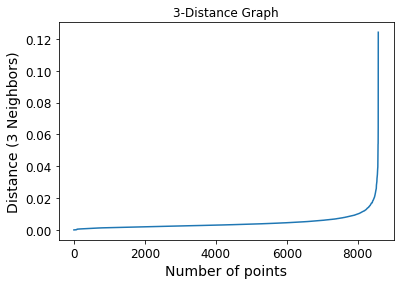

In [54]:
plt.plot(list(range(1, num_points + 1)), distanceDec);
plt.xlabel("Number of points");
plt.ylabel("Distance (3 Neighbors)");
plt.title("3-Distance Graph");

In [47]:
distances.mean()

0.0009077967948894046

In [49]:
k = 15
num_points = X.shape[0]
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)

In [50]:
distances, indices = nbrs.kneighbors(X)

In [51]:
distanceDec = sorted(distances[:, k-1], reverse = False)

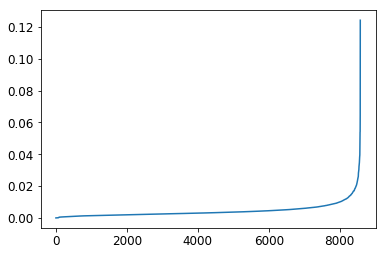

In [52]:
plt.plot(list(range(1, num_points + 1)), distanceDec);

In [29]:
from sklearn.metrics.cluster import normalized_mutual_info_score, silhouette_score, calinski_harabaz_score

In [34]:
X_dense = X.toarray()

In [32]:
epsilon = 0.00318

In [35]:
ch_scores = []
for min_pts in np.arange(3, 22, 2):
    print("For eps: {}, minPts: {}".format(epsilon, min_pts))
    labels, core_pts, border_pts = DBSCAN(X, eps=epsilon, minPts=min_pts)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('  Estimated number of clusters: %d' % n_clusters_)
    if n_clusters_ in [0, 1]:
        continue
    labels = assign_noise_to_centroid(X, labels, recompute_centroid=True)

    try:
        score = calinski_harabaz_score(X_dense, labels)
        print("  Calinski Harabaz Score: %0.3f"
          % score)
        ch_scores.append(score)
    except:
        ch_scores.append(score)
        print("  Calinski Harabaz cannot be found on 1 cluster...")

For eps: 0.00318, minPts: 3
  Estimated number of clusters: 40
  Calinski Harabaz Score: 63.339
For eps: 0.00318, minPts: 5
  Estimated number of clusters: 16
  Calinski Harabaz Score: 220.360
For eps: 0.00318, minPts: 7
  Estimated number of clusters: 15
  Calinski Harabaz Score: 348.693
For eps: 0.00318, minPts: 9
  Estimated number of clusters: 13
  Calinski Harabaz Score: 428.588
For eps: 0.00318, minPts: 11
  Estimated number of clusters: 11
  Calinski Harabaz Score: 522.765
For eps: 0.00318, minPts: 13
  Estimated number of clusters: 9
  Calinski Harabaz Score: 1806.377
For eps: 0.00318, minPts: 15
  Estimated number of clusters: 12
  Calinski Harabaz Score: 1681.461
For eps: 0.00318, minPts: 17
  Estimated number of clusters: 13
  Calinski Harabaz Score: 1586.648
For eps: 0.00318, minPts: 19
  Estimated number of clusters: 11
  Calinski Harabaz Score: 1924.247
For eps: 0.00318, minPts: 21
  Estimated number of clusters: 16
  Calinski Harabaz Score: 2915.417


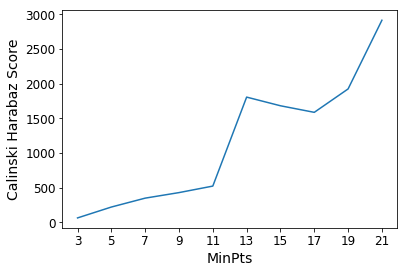

In [55]:
x = list(range(3, 22, 2))
y = ch_scores
plt.plot(x, y);
plt.xlabel("MinPts");
plt.ylabel("Calinski Harabaz Score");
plt.xticks(range(min(x), max(x)+1, 2));

In [37]:
sil_scores = []
for min_pts in np.arange(3, 22, 2):
    print("For eps: {}, minPts: {}".format(epsilon, min_pts))
    labels, core_pts, border_pts = DBSCAN(X, eps=epsilon, minPts=min_pts)
    labels = assign_noise_to_centroid(X, labels, recompute_centroid=True)
#         labels = assign_noise_KNN(X, labels, K = min_pts - 1)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('  Estimated number of clusters: %d' % n_clusters_)
    if n_clusters_ == 1:
        continue
    try:
        score = silhouette_score(X, labels, metric='cosine', random_state=8)
        print("  Silhouette Coefficient: %0.3f"
          % score)
        sil_scores.append(score)
    except:
        sil_scores.append(score)
        print("  Silhouette Coefficient cannot be found on 1 cluster...")

For eps: 0.00318, minPts: 3
  Estimated number of clusters: 40
  Silhouette Coefficient: -0.694
For eps: 0.00318, minPts: 5
  Estimated number of clusters: 16
  Silhouette Coefficient: -0.467
For eps: 0.00318, minPts: 7
  Estimated number of clusters: 15
  Silhouette Coefficient: -0.352
For eps: 0.00318, minPts: 9
  Estimated number of clusters: 13
  Silhouette Coefficient: -0.313
For eps: 0.00318, minPts: 11
  Estimated number of clusters: 11
  Silhouette Coefficient: -0.250
For eps: 0.00318, minPts: 13
  Estimated number of clusters: 9
  Silhouette Coefficient: 0.157
For eps: 0.00318, minPts: 15
  Estimated number of clusters: 12
  Silhouette Coefficient: 0.134
For eps: 0.00318, minPts: 17
  Estimated number of clusters: 13
  Silhouette Coefficient: 0.150
For eps: 0.00318, minPts: 19
  Estimated number of clusters: 11
  Silhouette Coefficient: 0.203
For eps: 0.00318, minPts: 21
  Estimated number of clusters: 16
  Silhouette Coefficient: 0.324


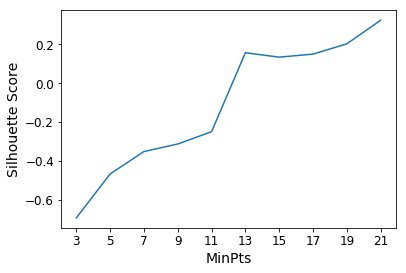

In [48]:
x = list(range(3, 22, 2))
y = sil_scores
plt.plot(x, y);
plt.xlabel("MinPts");
plt.ylabel("Silhouette Score");
plt.xticks(range(min(x), max(x)+1, 2));